In [182]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')


In [712]:
from collections import Iterable

from astropy.table import Table
from astropy.time import Time
import numpy as np
import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')
from scipy import interpolate
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd

from jetset.minimizer import fit_SED
from jetset.mcmc import McmcSampler

#plt.rcParams['figure.figsize'] = [15, 15]
#size=18
#params = {'legend.fontsize': size,
#          'figure.figsize': (20,8),
#          'axes.labelsize': size,
#          'axes.titlesize': size,
#          'xtick.labelsize': size*0.75,
#          'ytick.labelsize': size*0.75,
#          'axes.titlepad': 25}
#plt.rcParams.update(params)

mpl.rcParams['figure.figsize'] = [9., 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = '12'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [711]:
from jetset.model_parameters import ModelParameterArray, ModelParameter
from jetset.analytical_model import AnalyticalParameter
from jetset.base_model import Model
from jetset.model_manager import FitModel
from jetset.minimizer import fit_SED

# Models definition

In [785]:
class GrowthModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
        
        super(GrowthModel,self).__init__(  **keywords)
        self.name='GrowthModel'
        self.parameters = ModelParameterArray()      
        self.nu_min=-100
        self.nu_max=-100
        self.eta=1
        self.parameters.add_par(AnalyticalParameter(self,name='eta',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.R0=1
        self.parameters.add_par(AnalyticalParameter(self,name='R0',par_type='',val=1,val_min=0.,val_max=None,units=''))       
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=None,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=1,val_min=-100.,val_max=None,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return (1.0/self.eta)*np.power(self.R0,((nu-self.t_0)/self.tau))
    

In [827]:
class ExpModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(ExpModel,self).__init__(  **keywords)
        self.name='Exponential'
        self.nu_min=-100
        self.nu_max=-100
        self.parameters = ModelParameterArray()      
        self.R0=1
        self.parameters.add_par(AnalyticalParameter(self,name='R0',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=None,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=1,val_min=None,val_max=None,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return np.power(self.R0,((nu-self.t_0)/self.tau))
    

In [828]:
class LogisticPDFModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(LogisticPDFModel,self).__init__(  **keywords)
        self.name='LogisticPDFModel'
        self.nu_min=-100
        self.nu_max=-100
        self.parameters = ModelParameterArray()      
        self.N=1
        self.parameters.add_par(AnalyticalParameter(self,name='N',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=None,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=None,val_max=None,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        y=np.exp(-(nu-self.t_0)/self.tau)
        return (y*self.N/self.tau)/(1+y)**2
    

In [829]:
class Gompertz(Model):
    """
    Class to handle function for growth model
    """
   
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(Gompertz,self).__init__(  **keywords)
        self.name='Gompertz'
        self.nu_min=-100
        self.nu_max=-100
        self.parameters = ModelParameterArray()      
        self.N=1
        self.parameters.add_par(AnalyticalParameter(self,name='N',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=None,val_max=None,units=''))
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0,val_max=None,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        y= -self.t_0*np.exp(-nu/self.tau)
        return np.exp(y)*self.N
    

In [830]:
class LogisticModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(LogisticModel,self).__init__(  **keywords)
        self.name='LogisticModel'
        self.nu_min=-100
        self.nu_max=-100
        self.parameters = ModelParameterArray()      
        self.N=1
        self.parameters.add_par(AnalyticalParameter(self,name='N',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=None,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=None,val_max=None,units=''))
    
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        return self.N/(1+np.exp(-(nu-self.t_0)/self.tau))
    

In [831]:
class LogisticLogNconvModel(Model):
    """
    Class to handle function for growth model
    """
    
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(LogisticLogNconvModel,self).__init__(  **keywords)
        self.name='LogisticLogNconvModel'
        self.nu_min=-100
        self.nu_max=100
        self.nu_min_fit=-100
        self.nu_max_fit=100
        self.parameters = ModelParameterArray()      
        self.N=1
        self.parameters.add_par(AnalyticalParameter(self,name='N',par_type='',val=1,val_min=0,val_max=None,units=''))        
        self.tau=1
        self.parameters.add_par(AnalyticalParameter(self,name='tau',par_type='',val=1,val_min=0.,val_max=None,units=''))
        self.t_0=1
        self.parameters.add_par(AnalyticalParameter(self,name='t_0',par_type='',val=0,val_min=None,val_max=None,units=''))
        self.s=1
        self.parameters.add_par(AnalyticalParameter(self,name='s',par_type='',val=0.5,val_min=0.,val_max=1,units=''))
        self.scale=1
        self.parameters.add_par(AnalyticalParameter(self,name='scale',par_type='',val=15.5,val_min=1.,val_max=60,units=''))
        
    def set(self,**keywords):
        super(GrowthMode,self).set(**keywords )

        """
        sets a parameter value checking for physical boundaries 
        """
        if 'val' in keywords.keys():
            self.assign_val(self.name,keywords['val']) 

    def assign_val(self,name,val):
        setattr(self.polymodel,name,val)
    
    #def lin_func(self,nu):        
    #    return -np.log10(self.eta) +(np.log10(self.R0)/self.tau)*(nu-self.eta)
    
    def lin_func(self,nu):
        
        
        try:
            #r = logistic.rvs(size=10000,scale=3,loc=20)
            r = logistic(scale=self.tau, loc=self.t_0)
            #l = lognorm.rvs(s=0.4,scale=17.2,loc=0,size=10000)
            l = lognorm(s=self.s,scale=self.scale,loc=0)
            delta = .1
            #print('-->',nu.min()-1,nu.max()+1)
            big_grid = np.arange(-100,100,delta)

            pmf1 = r.pdf(big_grid)  
            pmf2 = l.pdf(big_grid)  
            conv_pmf = sp.signal.fftconvolve(pmf1,pmf2,'same') # Convolved probability mass function
            conv_pmf = conv_pmf/np.trapz(conv_pmf,big_grid)
            y=np.cumsum(conv_pmf)*delta
           
            
            f = interpolate.interp1d(big_grid, y)
            return self.N*f(nu)
        except:
            #print(nu)
            return nu
        


In [832]:
class LogisticLogNconvModelPDF(LogisticLogNconvModel):
    def __init__(self,nu_size=100,**keywords):
        """
        """
     
        super(LogisticLogNconvModelPDF,self).__init__(  **keywords)
        self.name='LogisticLogNconvModelPDF'
    def lin_func(self,nu):
        
        
        try:
            #r = logistic.rvs(size=10000,scale=3,loc=20)
            r = logistic(scale=self.tau, loc=self.t_0)
            #l = lognorm.rvs(s=0.4,scale=17.2,loc=0,size=10000)
            l = lognorm(s=self.s,scale=self.scale,loc=0)
            delta = .1
            #print('-->',nu.min()-1,nu.max()+1)
            big_grid = np.arange(-100,100,delta)

            pmf1 = r.pdf(big_grid)  
            pmf2 = l.pdf(big_grid)  
            conv_pmf = sp.signal.fftconvolve(pmf1,pmf2,'same') # Convolved probability mass function
            conv_pmf = conv_pmf/np.trapz(conv_pmf,big_grid)
            
           
            
            f = interpolate.interp1d(big_grid, conv_pmf)
            return self.N*f(nu)
        except:
            #print(nu)
            return nu

# Data import

In [436]:
class Data(object):
    
    def __init__(self,data,time):
        self.data=data
        self.time=time

In [437]:
def get_data_jh(name='Confirmed',country='Italy',fake_error=False):
    """
    name= Confirmed, Deaths, Recovered
    """
    table=Table.read('COVID-19-JH/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-%s.csv'%name)
    ts=table[table['Country/Region']==country]
    df=ts.to_pandas()
    
    y=df.values
    y=y.flatten()[4:].astype(np.int)
    t=df.columns[4:]
    msk=y>0
    
    #to get each time integer from 1 to N (rather than 0 N-1)
    #dates start from 1 not 0
    time=np.arange(1,len(t)+1)
    t=t[msk]
    if fake_error is False:
        y_err= np.sqrt(y[msk])
    else:
        y_err= np.ones(y[msk].size)*0.0001
        
    data_table=Table([time[msk], y[msk], y_err, np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,pd.to_datetime(t,format='%m/%d/%y').date)
    return data,df

def get_data_protezione_civile(name='deceduti',fake_error=False,regione=None,exclude=False):
    if regione is None:
        table=Table.read('COVID-19-PROTEZIONECIVILE/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
        df=table.to_pandas()
        #df[name]=df[name].astype(int)
    else:
        if isinstance(regione,Iterable):
            pass
        else:
            regione=[regione]
        if exclude is True:
            table=Table.read('COVID-19-PROTEZIONECIVILE/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
            df_full=table.to_pandas()
            #df_full[name]=df_full[name].astype(int)
            #print('df_full exclude TRue',df_full[name])
        for ID,reg in enumerate(regione):
            table=Table.read('COVID-19-PROTEZIONECIVILE/dati-regioni/dpc-covid19-ita-regioni.csv')
            df=table.to_pandas()
            
            df=df[df['denominazione_regione']==reg]
            df=df.reset_index()
            df[name]=df[name].astype(int)
            #print('df from reading',df[name])
            if exclude is True:
                df_full[name]=df_full[name] -df[name] 
                #print('df_full excldue true in loop',ID,df_full[name])
            else:
                if ID>=1:
                    df[name]=df[name] +df_old 
                else:
                    df_old=df[name] 
                #print('df exclude false in loop',ID,df[name])
            
                
        if exclude is True:
            df=df_full
            #print('df finale exclude True',ID,df[name])
        else:
            #print('df finale exclude False',ID,df[name])
            df=df.reset_index()
    
    t=df['data']
    t=pd.to_datetime(t)
    time=np.arange(1,len(t)+1)
    #print(df[name])
    y=df[name].astype(int)
    #print('y',y)
    msk=y>0
    t=t[msk]
    if fake_error is False:
        y_err= np.sqrt(y[msk])
    else:
        y_err= np.ones(y[msk].size)*0.0001

    data_table=Table([time[msk] , y[msk] , y_err[msk], np.zeros(len(y[msk]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    data=Data(data_table,np.array(t.dt.date))
    
    y_diff=np.diff(y[msk])
    t_ime_diff=time[msk][1::]
    if fake_error is False:
        y_err_diff= np.sqrt(y_diff)
    else:
        y_err_diff= np.ones(y_diff.size)*0.0001
    data_table_diff=Table([t_ime_diff , y_diff , y_err_diff, np.zeros(len(y_diff),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
    t_diff=t[msk][1::]
    
    data_diff=Data(data_table_diff,np.array(t_diff.dt.date))
    return data,data_diff,df


# Analysis and plot functions

In [723]:
def plot_model(mcmc,
               model,
               data,
               t_start_model=None, 
               t_stop_model=None, 
               size=10,
               mcmc_samples=500,
               labels=None,
               label='',
               title='',
               do_derivative=True,
               y_label='Cumulative Counts',
               logscale=True,
               figsize=(8,10)):
    
    fig = plt.figure(constrained_layout=True,figsize=figsize)
    
    if do_derivative is True:
        widths = [1]
        heights = [1, .2, 1]
        spec = fig.add_gridspec(ncols=1, nrows=3, width_ratios=widths, height_ratios=heights,hspace=0.4)

        ax1 = fig.add_subplot(spec[0])
        ax2 = fig.add_subplot(spec[1],sharex=ax1)
        ax3 = fig.add_subplot(spec[2],sharex=ax2)
    else:
        widths = [1]
        heights = [1, .2,]
        spec = fig.add_gridspec(ncols=1, nrows=2, width_ratios=widths, height_ratios=heights,hspace=0.4)

        ax1 = fig.add_subplot(spec[0])
        ax2 = fig.add_subplot(spec[1],sharex=ax1)
    
    if t_start_model is None:
        t_start_model = model.nu_min_fit
    
    if t_stop_model is None:
        t_stop_model = model.nu_max_fit
        
    nu=np.arange(t_start_model,t_stop_model,1)
    
    if hasattr(model,'GrowthModel'):
        p=np.log10(model.GrowthModel.parameters.R0.best_fit_val)/model.GrowthModel.parameters.tau.val
    
    if mcmc is not None:
        mcmc.reset_to_best_fit()
        y = np.zeros((size,nu.size))

        for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=mcmc_samples)):
            for ID_par,pi in  enumerate(mcmc.par_array):
                pi.set(val = mcmc.get_par(ID_par)[0][ID_rand])

            y[ID] = model.eval(nu,get_model=True)

        #print(ID)
        y_min=np.amin(y, axis=0)
        y_max=np.amax(y, axis=0)
        ax1.fill_between(nu,y_max,y_min,color='gray',alpha=0.3)

        mcmc.reset_to_best_fit()
    y_bf=model.eval(nu,get_model=True)
    if hasattr(model,'GrowthModel'):
        txt=': Predicted\nlog10(R0)/tau=%3.3f'%p
    else:
        txt=': Predicted'
    ax1.plot(nu,y_bf,label= label+txt)
    
    ax1.errorbar(data.data['nu_data'],data.data['nuFnu_data'],yerr=data.data['dnuFnu_data'],fmt='o',label = label+': Observed')
    
    ax1.axvline(model.nu_min_fit,alpha=0.5)
    ax1.axvline(model.nu_max_fit,alpha=0.5)
    
    
    #set x ticks and lables
    locs, labels = plt.xticks()
    
    #add 100 days to final date in data
    delta_t=pd.date_range(data.time[-1], periods=100, freq='d')[1:]
    t=np.append(data.time,delta_t.date)
    delta_x=data.data['nu_data'][-1]+np.arange(1,len(t)-len(data.data['nu_data'])+1)
   
    #sfit letf by 1 to align time with x thicks 
    x=np.append(data.data['nu_data'],delta_x)
    
    ax1.set_xticks(x[::2])
    ax1.set_xticklabels(t[::2],rotation=90)

    
    ax1.set_ylabel(y_label)
    if logscale is True:

        ax1.semilogy()
     
    ax1.legend(loc='best')
     
    ax1.set_xlim(t_start_model-1,t_stop_model)
    ax1.get_xaxis().set_visible(False)
    
    
    
    x_res,y_res=model.get_residuals(log_log=False,data=data.data)
    msk1 = x_res<model.nu_max_fit
    msk2 =x_res>model.nu_min_fit
    x_res=x_res[msk1*msk2]
    y_res=y_res[msk1*msk2]
    line = ax2.errorbar(x_res, y_res, yerr=np.ones(x_res.size), fmt='+')
    ax2.axhline(0,ls='--',alpha=0.5)
    
    ax2.set_xticks(x[::2])
    ax2.set_xticklabels(t[::2],rotation=90)
    ax2.set_xlim(t_start_model-1,t_stop_model)
    #ax2.set_xticklabels(t,rotation=45)
    #plt.setp(ax2.get_xticklabels(), ha="right", rotation=90)
    
    #Derivative
    if do_derivative is True:
        ax3.plot(nu  ,np.gradient(y_bf,nu,edge_order=2 ),label='model')

        if mcmc is not None:
            y_der = np.zeros((size,nu.size))
            for ID,ID_rand in enumerate(np.random.randint(len(mcmc.samples), size=mcmc_samples)):
                for ID_par,pi in  enumerate(mcmc.par_array):
                    pi.set(val = mcmc.get_par(ID_par)[0][ID_rand])
                y[ID] = model.eval(nu,get_model=True)
                y_der[ID] = np.gradient(y[ID],nu,edge_order=2) 

            y_min=np.amin(y_der, axis=0)
            y_max=np.amax(y_der, axis=0)    
            ax3.fill_between(nu ,y_max  ,y_min  ,color='gray',alpha=0.3)

        ax3.plot(data.data['nu_data']  ,np.gradient(data.data['nuFnu_data'],data.data['nu_data']),'o',label='data')

        ax3.axvline(model.nu_min_fit,alpha=0.5)
        ax3.axvline(model.nu_max_fit,alpha=0.5)
        if logscale is True:
            ax3.semilogy()
        ax3.set_xticks(x[::2])
        ax3.set_xticklabels(t[::2],rotation=90)
        ax3.set_xlabel('date')
        ax3.set_ylabel('derivative of %s'%y_label)
        ax3.set_xlim(t_start_model-1,t_stop_model)
        ax3.legend(loc='best')

    plt.tight_layout()
    fig.suptitle(title,y=1.02)
    
    
    #plt.subplots_adjust(hspace=.0)
    return fig

In [729]:
def do_analysis(model,
                data,
                t_start,
                t_stop,
                t_start_model,
                t_stop_model,
                name,
                do_plot=True,
                do_mcmc=True,
                mcmc_steps=500,
                title='',
                do_derivative=True,
                y_label='Cumulative Counts',
                logscale=True,
                figsize=(8,10)):


    model.nu_min=0
    model.nu_max=100
    
    
    fm=FitModel(analytical=model,name='test')
    fm.nu_min_fit=t_start
    fm.nu_max_fit=t_stop
    bfm,mm=fit_SED(fm,data,nu_fit_start=t_start,nu_fit_stop=t_stop,minimizer='minuit',silent=True)
    
    if hasattr(model,'R0'):
        log_R0_by_tau=np.log10(model.parameters.R0.val)/model.parameters.tau.val
        print('log10(R0)/tau',log_R0_by_tau)
        print('doubling time',np.log10(2)/log_R0_by_tau)

    bfm.fit_Model.show_best_fit_pars()
    if do_mcmc is True:
        mcmc=McmcSampler(bfm)
        mcmc.run_sampler(nwalkers=150,burnin=10,steps=mcmc_steps,bound=2,bound_rel=True,walker_start_bound=0.001,threads=1)
        print('bounds',mcmc._bounds)
    else:
        mcmc = None
    if do_plot is True:
        fig=plot_model(mcmc,bfm.fit_Model,data,t_start_model=t_start_model,t_stop_model= t_stop_model,label=name,size=100,mcmc_samples=100,title=title,do_derivative=do_derivative,y_label=y_label,logscale=logscale,figsize=figsize)
    
    fig_corner=None
    if mcmc is not None:
        fig_corner=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
        fig_corner.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)

    plt.tight_layout()
        
        
        

    return bfm,mm,mcmc,data,fig,fig_corner

# Model fitting

## Logistic

  1%|          | 4/500 [00:00<00:14, 34.36it/s]

  model name  name bestfit val     err +     err -  start val   fit range min fit range max frozen
------------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticModel    N 3.963110e+03 1.491335e+02    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  tau 3.578066e+00 5.462660e-02    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  t_0 2.382704e+01 2.752951e-01    -- 0.000000e+00 -1.000000e+02            --  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 51.35it/s]


mcmc run done, with 1 threads took 9.76 seconds
bounds [[0, 11889.329532578175], [0.0, 10.734198938493904], [-23.827035927542894, 71.48110778262868]]

**************************************************************************************************
Fit report

Model: None
  model name  name par type units     val      phys. bound. min phys. bound. max  log  frozen
------------- ---- -------- ----- ------------ ---------------- ---------------- ----- ------
LogisticModel    N                3.852223e+03     0.000000e+00               -- False  False
LogisticModel  tau                3.552733e+00     0.000000e+00               -- False  False
LogisticModel  t_0                2.366969e+01    -1.000000e+02               -- False  False

converged=True
calls=237
------------------------------------------------------------------
| FCN = 120.4                   |     Ncalls=236 (236 total)     |
| EDM = 3.88E-06 (Goal: 1E-05)  |            up = 1.0            |
-----------------------------

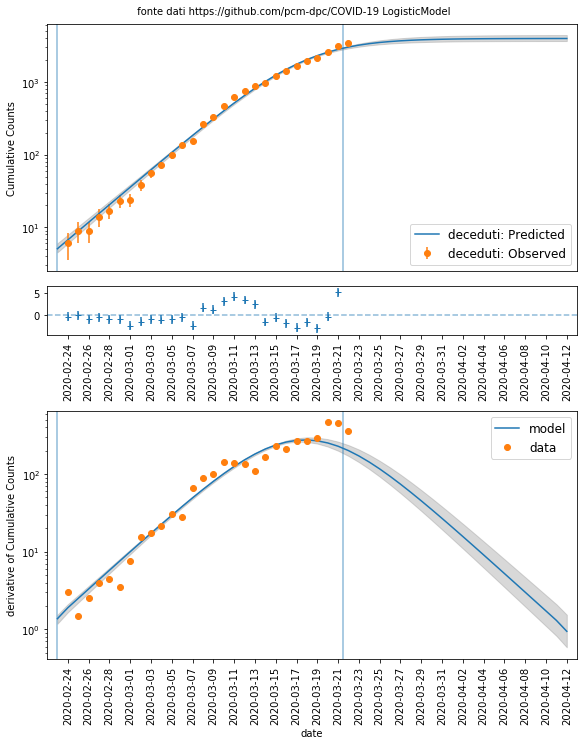

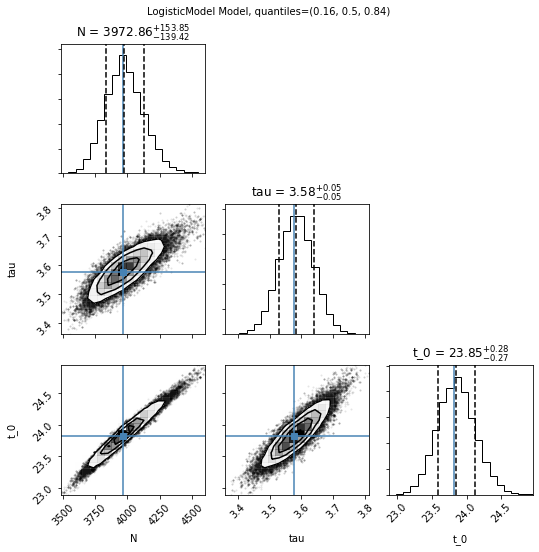

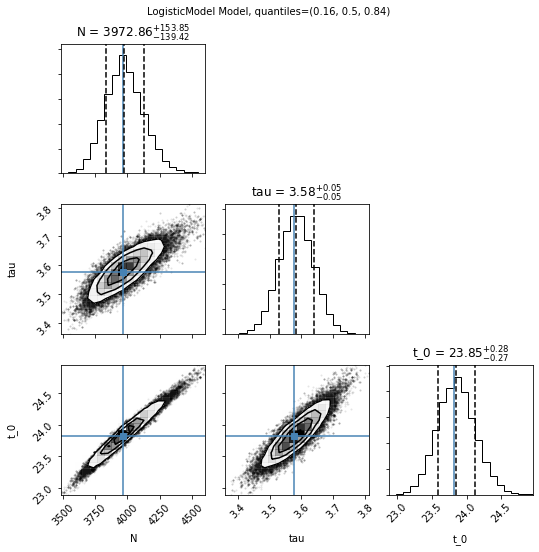

In [803]:
name='deceduti'
data,data_diff,df =get_data_protezione_civile(name,fake_error=False,exclude=False,regione=['Lombardia'])
model=LogisticModel()
#model.parameters.t_0.val=-2
#model.parameters.tau.val=2

bfm,mm,mcmc,data,fig,fig_corner=do_analysis(model,
                                             data,
                                             t_start=0,
                                             t_stop=27.5,
                                             t_start_model=0,
                                             t_stop_model=50,
                                             name=name,
                                             mcmc_steps=500,
                                             title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s'%model.name,
                                             do_mcmc=True,
                                             do_derivative=True)
if mcmc is not None:
    f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
    f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)

plt.tight_layout()
print(mm.show_report())

## Exponential

  1%|          | 6/500 [00:00<00:08, 58.45it/s]

log10(R0)/tau 0.06802230403299298
doubling time 4.425460147865207
 model name name  bestfit val     err +     err -  start val   fit range min fit range max frozen
----------- ---- ------------- ------------ ----- ------------ ------------- ------------- ------
Exponential   R0  1.267545e+00 1.930152e-02    -- 1.000000e+00  0.000000e+00            --  False
Exponential  tau  1.513673e+00 9.509929e-02    -- 1.000000e+00  0.000000e+00            --  False
Exponential  t_0 -3.826277e+01 1.482405e-01    -- 1.000000e+00 -1.000000e+02            --  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 53.57it/s]


mcmc run done, with 1 threads took 9.35 seconds
bounds [[0, 3.8026363819723783], [0.0, 4.541019850819158], [-100.0, 38.26277358461831]]


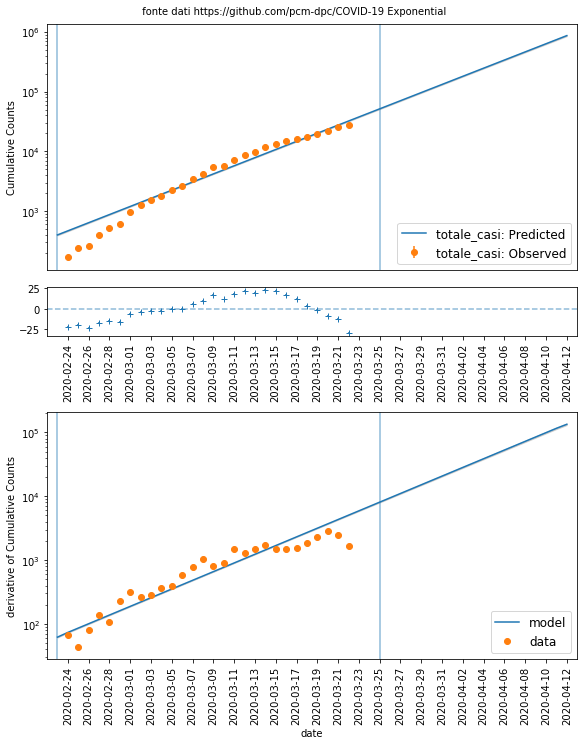

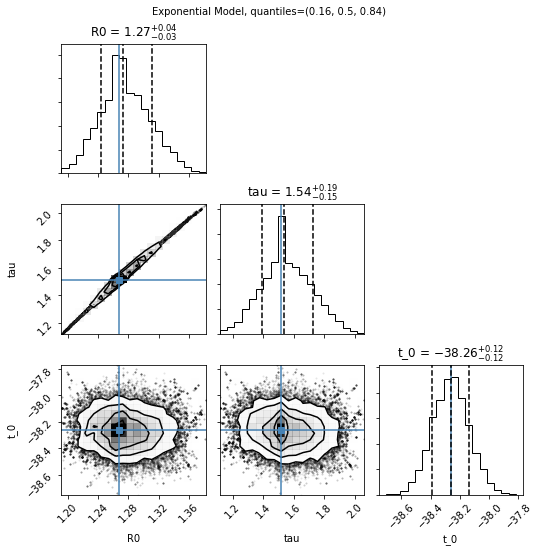

In [825]:
name='totale_casi'
data,data_diff,df =get_data_protezione_civile(name,fake_error=False,regione=['Lombardia'])
 
model=ExpModel()
#model.parameters.tau.val=5
#model.parameters.t_0.frozen=True
#model.parameters.R0.val=3
bfm,mm,mcmc,data,fig,fig_corner=do_analysis(model,
                                         data,
                                         t_start=0,
                                         t_stop=31,
                                         t_start_model=0,
                                         t_stop_model=50,
                                         name=name,
                                         mcmc_steps=500,
                                         title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s'%model.name,
                                         do_mcmc=True,
                                         do_derivative=True,
                                         logscale=True,
                                         figsize=(8,10))


In [810]:
np.arange(1,38,dt)

array([ 1,  8, 15, 22, 29, 36])

log10(R0)/tau 0.10719553145139613
doubling time 2.808232690188883
 model name name  bestfit val     err +     err -  start val   fit range min fit range max frozen
----------- ---- ------------- ------------ ----- ------------ ------------- ------------- ------
Exponential   R0  1.317501e+00 1.274865e+00    -- 1.000000e+00  0.000000e+00            --  False
Exponential  tau  1.117128e+00 2.652889e+00    -- 1.000000e+00  0.000000e+00            --  False
Exponential  t_0 -6.442274e+00 2.439412e+00    -- 1.000000e+00            --            --  False
log10(R0)/tau 0.13746965471415953
doubling time 2.189792331186926
 model name name  bestfit val     err +     err -  start val   fit range min fit range max frozen
----------- ---- ------------- ------------ ----- ------------ ------------- ------------- ------
Exponential   R0  1.466882e+00 1.625093e+00    -- 1.000000e+00  0.000000e+00            --  False
Exponential  tau  1.210415e+00 2.161825e+00    -- 1.000000e+00  0.000000e+00        

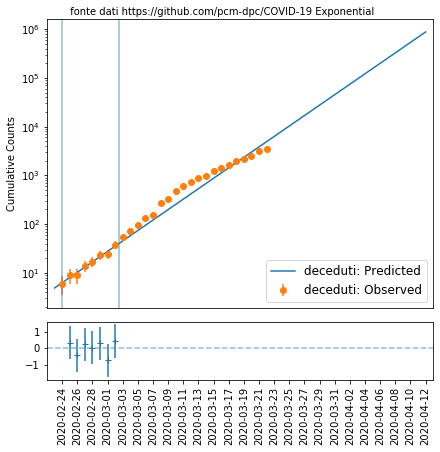

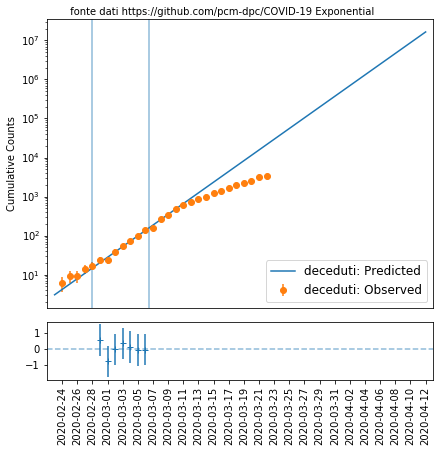

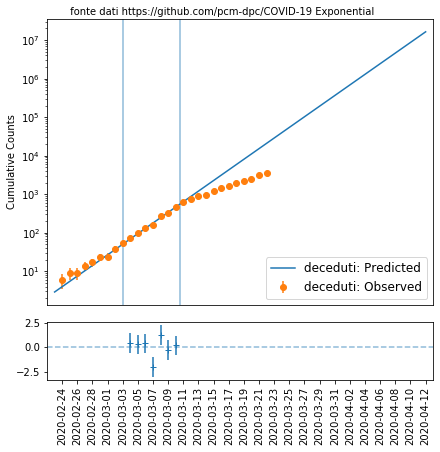

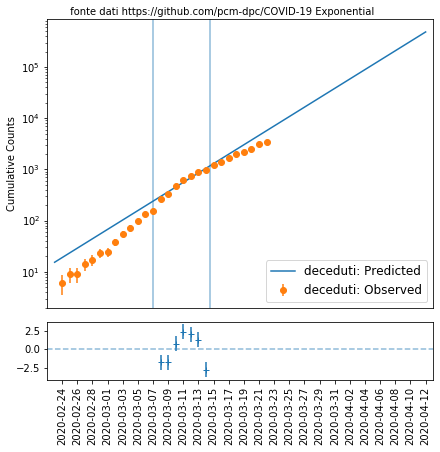

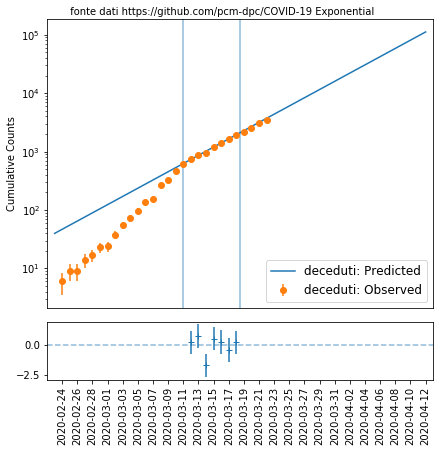

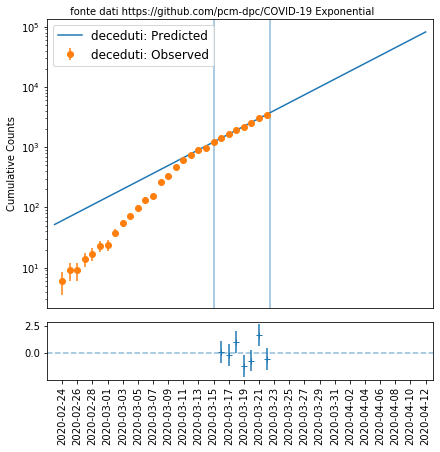

In [836]:
name='deceduti'
data,data_diff,df =get_data_protezione_civile(name,fake_error=False,regione=['Lombardia'])
dt=4
for t in np.arange(1,24,dt):
    model=ExpModel()
    #model.parameters.tau.val=5
    #model.parameters.t_0.frozen=True
    #model.parameters.R0.val=3
    bfm,mm,mcmc,data,fig,fig_corner=do_analysis(model,
                                             data,
                                             t_start=t,
                                             t_stop=t+7.5,
                                             t_start_model=0,
                                             t_stop_model=50,
                                             name=name,
                                             mcmc_steps=500,
                                             title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s'%model.name,
                                             do_mcmc=False,
                                             do_derivative=False,
                                             logscale=True,
                                             figsize=(6,6))
    
    
   

    


## Gompertz Model

  1%|          | 5/500 [00:00<00:10, 46.19it/s]

model name name bestfit val     err +     err -  start val   fit range min fit range max frozen
---------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
  Gompertz    N 7.976729e+04 1.293488e+04    -- 1.000000e+00  0.000000e+00            --  False
  Gompertz  t_0 1.078038e+01 7.299472e-02    -- 0.000000e+00            --            --  False
  Gompertz  tau 2.015931e+01 8.153911e-01    -- 1.000000e+00  0.000000e+00            --  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 54.69it/s]


mcmc run done, with 1 threads took 9.20 seconds
bounds [[0, 239301.8663344856], [-10.780383622302864, 32.34115086690859], [0, 60.47794132100506]]


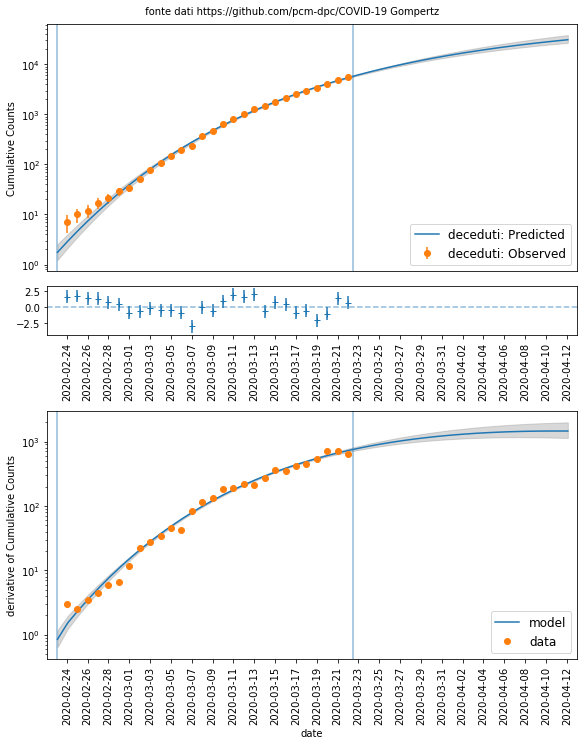

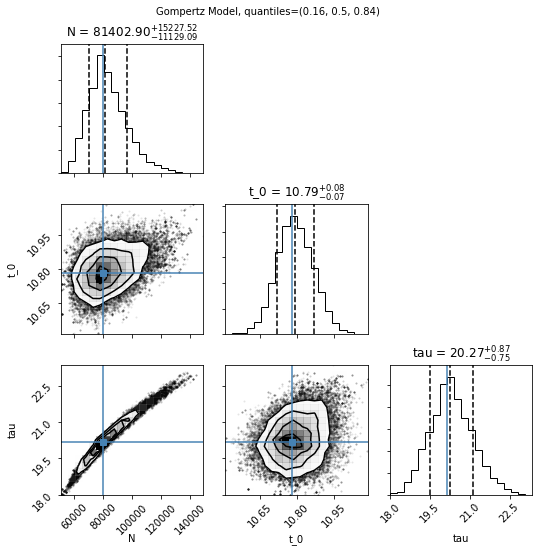

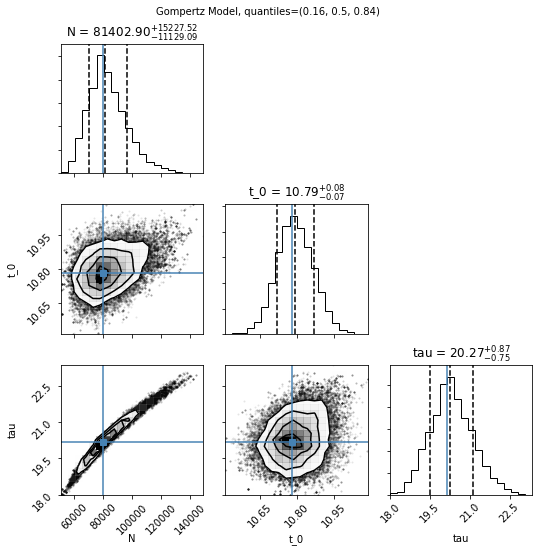

In [850]:
name='deceduti'
data,data_diff,df =get_data_protezione_civile(name,fake_error=False)
model=Gompertz()
bfm,mm,mcmc,data,fig,fig_corner=do_analysis(model,data,t_start=0.1,t_stop=28.5,t_start_model=0.1,t_stop_model=50,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s '%model.name,do_mcmc=True)
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)
plt.tight_layout()
#print(mm.show_report())
#print(np.sum(~np.isfinite(mcmc.samples_log_prob)))

# LogisticLogNconvModel

      model name       name bestfit val     err +     err -  start val   fit range min fit range max frozen
--------------------- ----- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticLogNconvModel     N 1.457862e+04 6.025741e+02    -- 1.000000e+04  0.000000e+00            --  False
LogisticLogNconvModel   tau 3.197170e+00 6.292107e-02    -- 3.800000e+00  0.000000e+00            --  False
LogisticLogNconvModel   t_0 1.155927e+01 3.042826e-01    -- 0.000000e+00 -3.000000e+01            --  False
LogisticLogNconvModel     s           --           --    -- 5.000000e-01  0.000000e+00  1.000000e+00   True
LogisticLogNconvModel scale           --           --    -- 2.000000e+01  1.000000e+00  6.000000e+01   True
mcmc run starting


100%|██████████| 500/500 [03:22<00:00,  2.47it/s]


mcmc run done, with 1 threads took 202.96 seconds
bounds [[0, 43735.86771798708], [0.0, 9.5915113522945], [-11.55926541278506, 34.67779623835518]]

**************************************************************************************************
Fit report

Model: None
      model name       name par type units     val      phys. bound. min phys. bound. max  log  frozen
--------------------- ----- -------- ----- ------------ ---------------- ---------------- ----- ------
LogisticLogNconvModel     N                1.509529e+04     0.000000e+00               -- False  False
LogisticLogNconvModel   tau                3.248863e+00     0.000000e+00               -- False  False
LogisticLogNconvModel   t_0                1.181732e+01    -3.000000e+01               -- False  False
LogisticLogNconvModel     s                5.000000e-01     0.000000e+00     1.000000e+00 False   True
LogisticLogNconvModel scale                2.000000e+01     1.000000e+00     6.000000e+01 False   True

converg

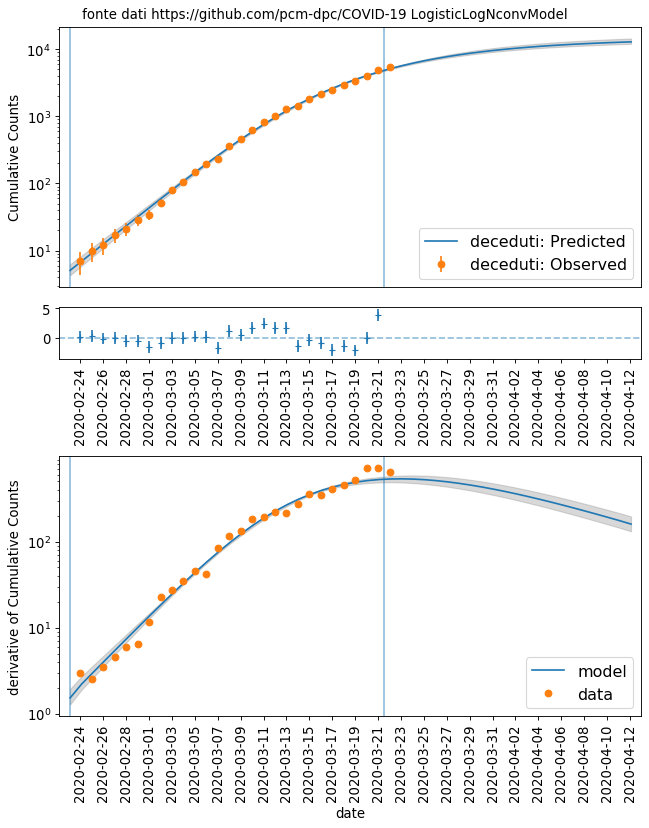

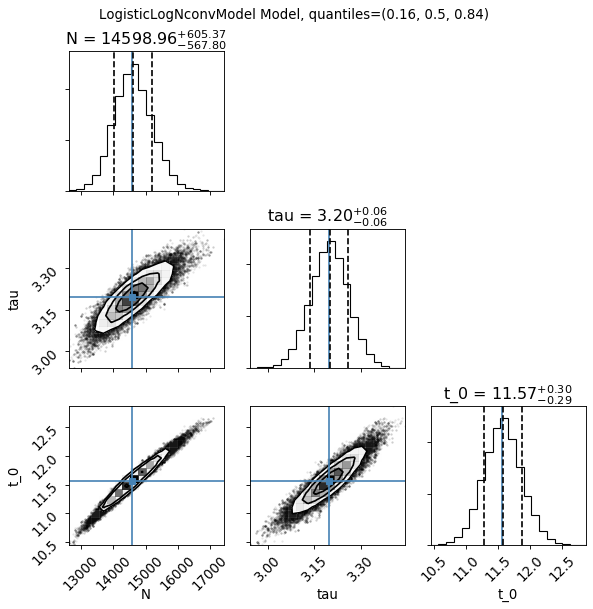

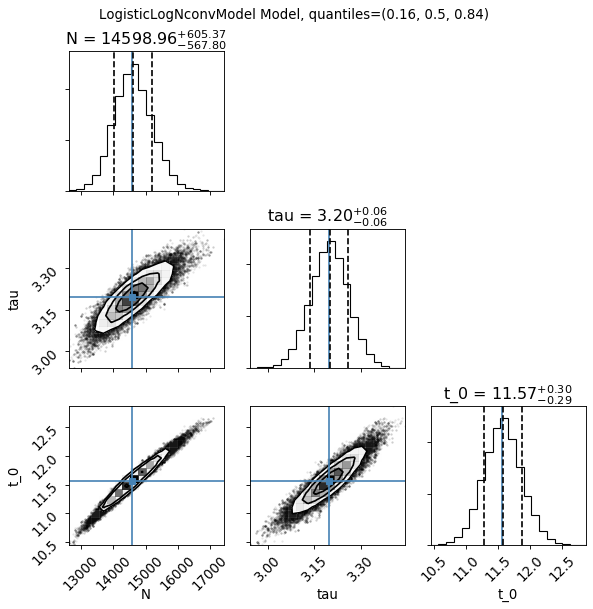

In [744]:
name='deceduti'
data,data_diff,df =get_data_protezione_civile(name,fake_error=False)
model=LogisticLogNconvModel()
model.parameters.N.val=10000
model.parameters.tau.val=3.8
model.parameters.s.val=0.5
model.parameters.s.frozen=True
model.parameters.scale.val=20
model.parameters.scale.frozen=True


bfm,mm,mcmc,data,fig,fig_corner=do_analysis(model,data,t_start=0.1,t_stop=27.5,t_start_model=0.1,t_stop_model=50,name=name,mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s '%model.name,do_mcmc=True)
print(mm.show_report())
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)
plt.tight_layout()

       model name         name  bestfit val     err +     err -  start val   fit range min fit range max frozen
------------------------ ----- ------------- ------------ ----- ------------ ------------- ------------- ------
LogisticLogNconvModelPDF     N  5.964717e+04 1.303125e+04    -- 2.000000e+02  0.000000e+00            --  False
LogisticLogNconvModelPDF   tau  2.249305e+00 4.180581e-01    -- 1.000000e+00  0.000000e+00            --  False
LogisticLogNconvModelPDF   t_0 -4.850170e+00 7.739250e+00    -- 0.000000e+00 -3.000000e+01            --  False
LogisticLogNconvModelPDF     s  4.006535e-01 1.140831e-01    -- 5.000000e-01  0.000000e+00  1.000000e+00  False
LogisticLogNconvModelPDF scale  5.999975e+01 5.663886e+00    -- 1.550000e+01  1.000000e+00  6.000000e+01  False
mcmc run starting


100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


mcmc run done, with 1 threads took 160.67 seconds
bounds [[0, 178941.5079271192], [0.0, 6.747915566686129], [-14.550510152172755, 4.850170050724252], [0.0, 1], [1.0, 60]]

**************************************************************************************************
Fit report

Model: None
       model name         name par type units      val      phys. bound. min phys. bound. max  log  frozen
------------------------ ----- -------- ----- ------------- ---------------- ---------------- ----- ------
LogisticLogNconvModelPDF     N                 5.964717e+04     0.000000e+00               -- False  False
LogisticLogNconvModelPDF   tau                 2.249305e+00     0.000000e+00               -- False  False
LogisticLogNconvModelPDF   t_0                -4.850170e+00    -3.000000e+01               -- False  False
LogisticLogNconvModelPDF     s                 4.006535e-01     0.000000e+00     1.000000e+00 False  False
LogisticLogNconvModelPDF scale                 5.999975e+01    

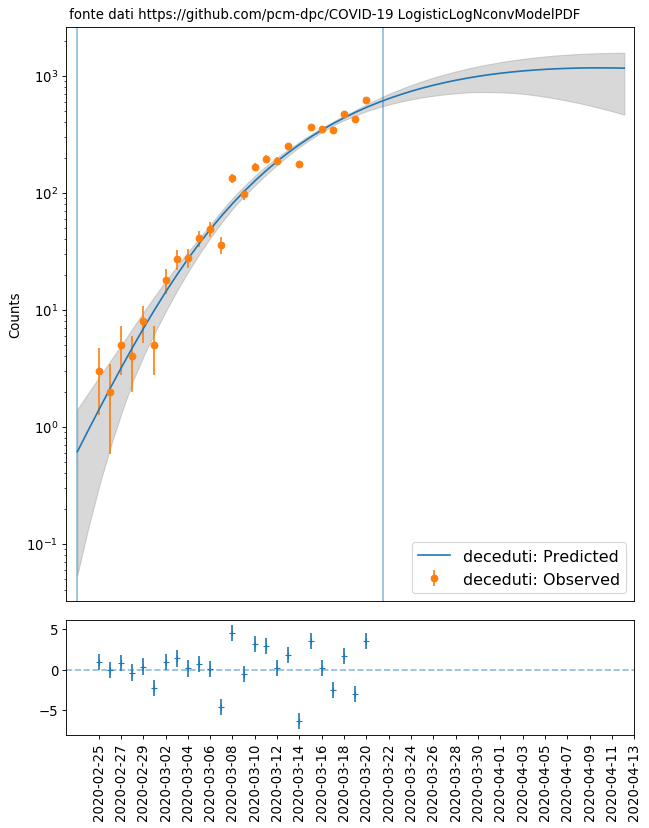

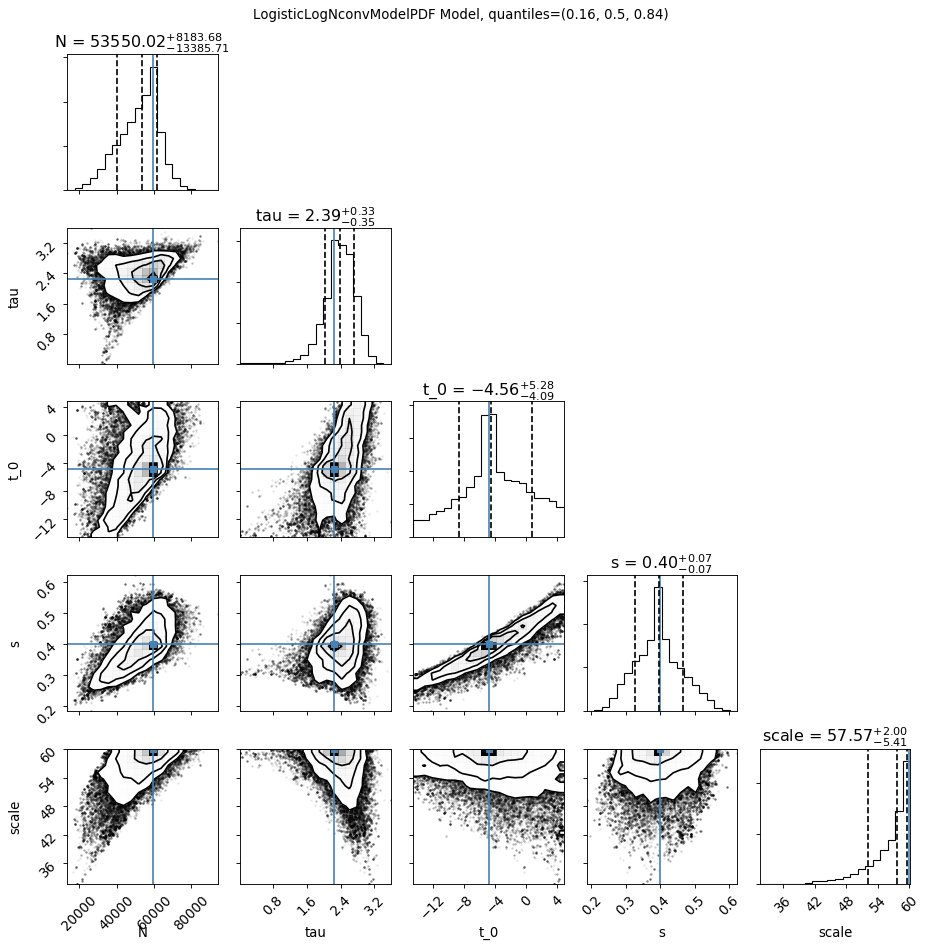

In [498]:
name='deceduti'
data,data_diff,df =get_data_protezione_civile(name,fake_error=False)
model=LogisticLogNconvModelPDF()
model.parameters.N.val=200
#model.parameters.tau.val=3
#model.parameters.s.val=0.8
#model.parameters.s.frozen=True
#model.parameters.scale.val=22
#model.parameters.scale.frozen=True


bfm,mm,mcmc,data,fig,fig_corner=do_analysis(model,
                                 data_diff,
                                 t_start=0.1,
                                 t_stop=27.5,
                                 t_start_model=0.1,
                                 t_stop_model=50,
                                 name=name,
                                 mcmc_steps=500,title=' fonte dati https://github.com/pcm-dpc/COVID-19 %s '%model.name,
                                 do_mcmc=True,
                                 do_derivative=False,
                                 y_label='Counts')
print(mm.show_report())
f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)
plt.tight_layout()

# Plot data trend

In [550]:

def plot_ratio(name,
               plot_vline=False,
               delta=5,
               po_ratio=1.2,
               gradient=True,
               running_mean_window=1,
               selected_regions=['Lombardia','Piemonte','Veneto','Emilia Romagna'],
               target_regions=None,
               skip_target=False,
               ratio_class=None,
               semilog=True):
    
    
    if selected_regions is None:
        selected_str = 'Italy'
    else:
        selected_str = str(selected_regions)
        
    if target_regions is None:
        target_str='Italy-Selected'
    else:
        target_str= str(target_regions)
    
    
    
    fig = plt.figure(figsize=(20,7))
    ax1=fig.add_subplot(1, 3, 1)   #top and bottom left
    ax2=fig.add_subplot(1, 3, 2)
    
    data_full,data_diff_full,df_full =get_data_protezione_civile(name,fake_error=False)
    
    df_full['data']=pd.to_datetime(df_full['data'])
    date_full=df_full['data'].array
    y_full=np.array(df_full[name].array)
    
    
        
    data_selected,data_diff_selected,df_selected =get_data_protezione_civile(name,fake_error=False,regione=selected_regions,exclude=False)
    if target_regions is None:
        data_rest,data_diff_rest,df_rest =get_data_protezione_civile(name,fake_error=False,regione=selected_regions,exclude=True)
    else:
        data_rest,data_diff_rest,df_rest =get_data_protezione_civile(name,fake_error=False,regione=target_regions,exclude=False)
    
    y_selected= np.array(df_selected[name].array) 
    y_rest= np.array(df_rest[name].array) 
    
    if ratio_class is not None:
        ratio_full=df_full[ratio_class].array 
        ratio_selected=df_selected[ratio_class].array 
        ratio_rest=df_rest[ratio_class].array 
    
    
    if gradient is True:
        y_full_diff=np.gradient(np.array(y_full),edge_order=2)
        y_selected_diff=np.gradient(np.array(y_selected),edge_order=2)
        y_rest_diff=np.gradient(np.array(y_rest),edge_order=2)
        date_diff=date_full
        if ratio_class is not None:
            ratio_full_diff=np.gradient(np.array(ratio_full),edge_order=2)
            ratio_selected_diff=np.gradient(np.array(ratio_selected),edge_order=2)
            ratio_rest_diff=np.gradient(np.array(ratio_rest),edge_order=2)
    else:
        y_full_diff=np.diff(np.array(y_full) )
        y_selected_diff=np.diff(np.array(y_selected) )
        y_rest_diff=np.diff(np.array(y_rest) )
        date_diff=date_full[1:]
        if ratio_class is not None:
            ratio_full_diff=np.diff(np.array(ratio_full) )
            ratio_selected_diff=np.diff(np.array(ratio_selected) )
            ratio_rest_diff=np.diff(np.array(ratio_rest) )
    
    
    if ratio_class is not None:
        #dive the full by the full
        
        y_full=  np.array(y_full/df_full[ratio_class].array)
        y_selected=  np.array(y_selected/df_selected[ratio_class].array)  
        y_rest=  np.array(y_rest/df_rest[ratio_class].array)  
        
        #divide by diff of ratio!
        y_full_diff=y_full_diff/ratio_full_diff
        y_selected_diff=y_selected_diff/ratio_selected_diff
        y_rest_diff=y_rest_diff/ratio_rest_diff
        
    
    
    
    if running_mean_window >1:
        y_selected=running_mean_uniform_filter1d(y_selected,running_mean_window)
        y_rest=running_mean_uniform_filter1d(y_rest,running_mean_window)
        #print(len(x))
        date=date_full[:-(running_mean_window-1)]
        #print(len(x),len(y_r),running_mean_window)
    
    
    if ratio_class is not None:
            name='%s/%s'%(name,ratio_class)
    for ID,ax in enumerate([ax1,ax2]):
        if ID==0:
            #y_full= np.array(y_full)
            y_selected_plot= y_selected
            y_rest_plot= y_rest
            date=date_full
        else:
            y_selected_plot= y_selected_diff
            y_rest_plot= y_rest_diff
            date=date_diff
        
         
        ax.plot(np.array(date),y_selected_plot ,'-o',label='Selected')
        
        #print ('target_regions',target_regions)
        if skip_target is False and target_regions is not None:
            ax.plot(np.array(date),y_rest_plot*po_ratio ,'-o',label='%s*%1.1f'%(target_str,po_ratio))

        if plot_vline is True:
            ax.axvline(df_full['data'][12],ls='--',c='r',label='north to south massive migration')
            ax.axvline(df_full['data'][14],ls='--',c='y',label='north lockdown')
        
        
        if skip_target is False and target_regions is not None:
            if delta is not None:
                date =date+ pd.DateOffset(days=-delta)
                #dx=df_full['data']
                #x=np.array(x)
                ax.plot(np.array(date),y_rest_plot*po_ratio ,'-o',label='%s*%1.1f shifted %1.1f days'%(target_str,po_ratio,delta))

        #ax.semilogx()
        #name='deaths'
        if ID==0:
            ax.set_ylabel('counts Cumulative')
        else:
            ax.set_ylabel('counts')

        ax.legend(loc='best',fontsize=12)
     
        if semilog is True:
            ax.semilogy()
        
        ax.set_title('%s\nSeleceted=%s'%(name,str(selected_str)))
        plt.draw()
        ax.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    if ratio_class is not None:
        ax3=fig.add_subplot(1, 3, 3)
        ax3.plot(ratio_full_diff,y_full_diff,'o')
        if skip_target is False and target_regions is not None:
            ax3.plot(ratio_rest_diff,y_rest_diff,'o')

        ax3.set_ylabel('%s'%name)
        ax3.set_xlabel('%s'%ratio_class)
        plt.draw()

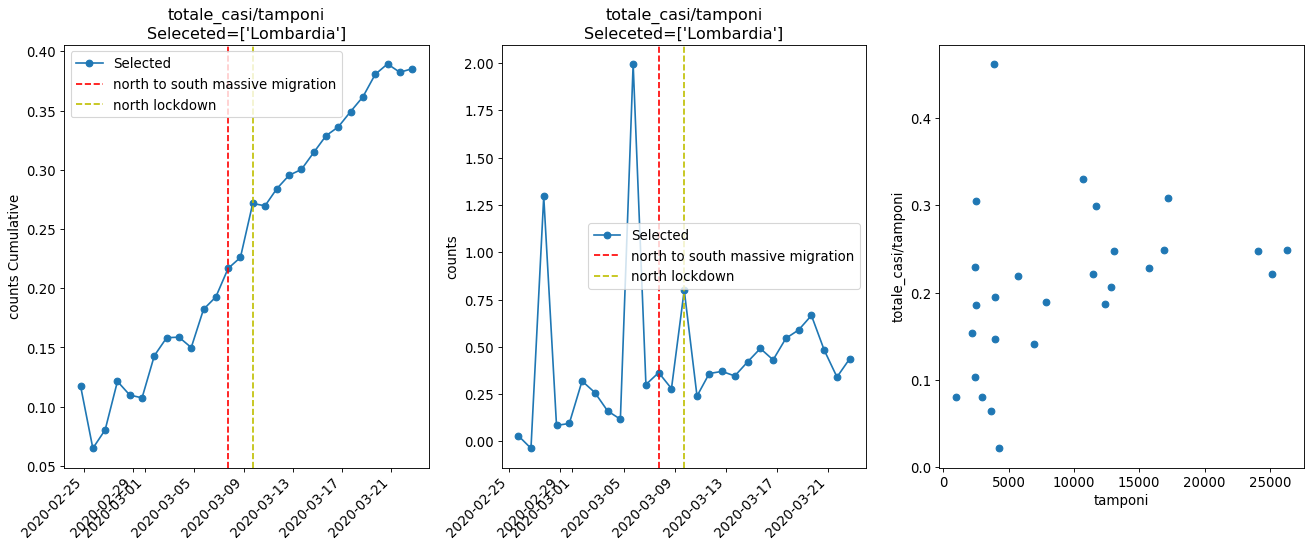

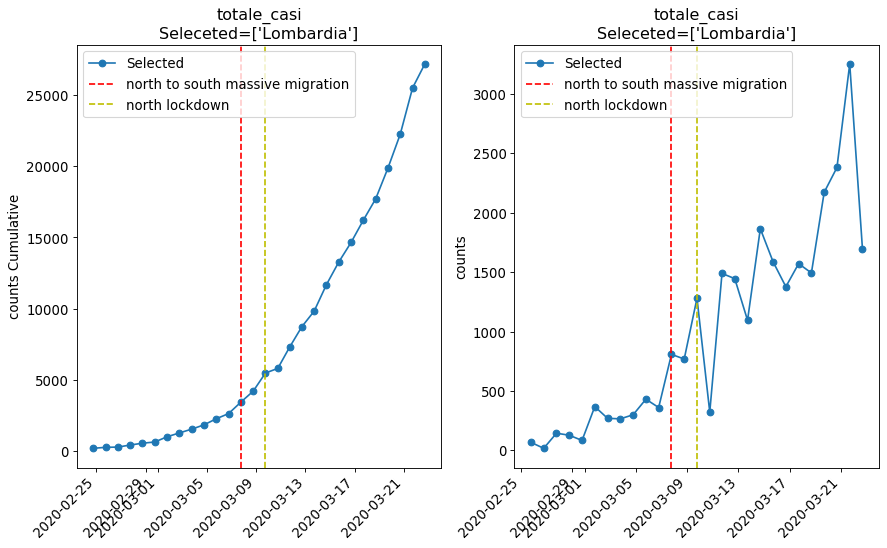

In [745]:
plot_ratio('totale_casi',plot_vline=True,delta=None,po_ratio=0.0,gradient=False,running_mean_window=0,ratio_class='tamponi',skip_target=True,selected_regions=['Lombardia'],semilog=False)
plot_ratio('totale_casi',plot_vline=True,delta=None,po_ratio=0.0,gradient=False,running_mean_window=0,skip_target=True,selected_regions=['Lombardia'],semilog=False)

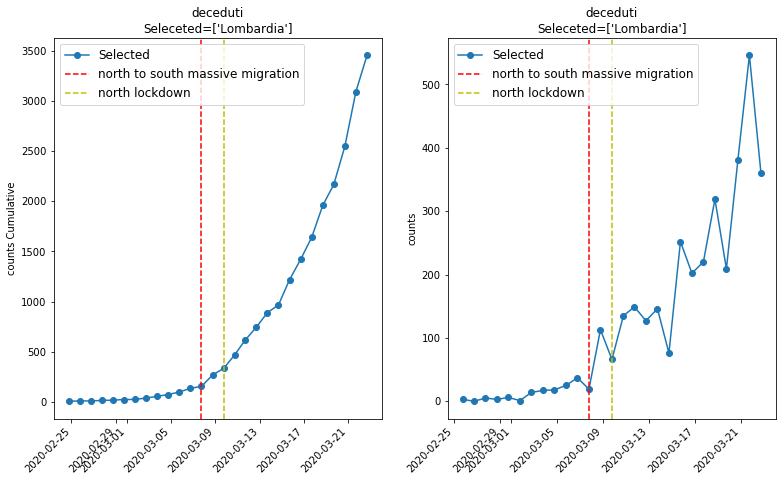

In [752]:
%matplotlib inline
plot_ratio('deceduti',plot_vline=True,delta=None,po_ratio=0.0,gradient=False,running_mean_window=0,skip_target=True,selected_regions=['Lombardia'],semilog=False)

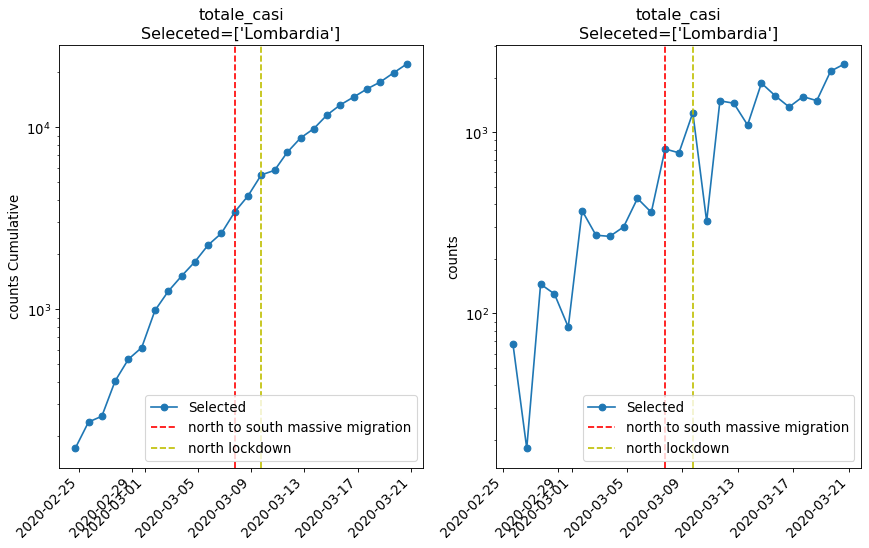

In [553]:
plot_ratio('totale_casi',plot_vline=True,delta=None,po_ratio=0.0,gradient=False,running_mean_window=0,skip_target=True,selected_regions=['Lombardia'])

<IPython.core.display.Javascript object>


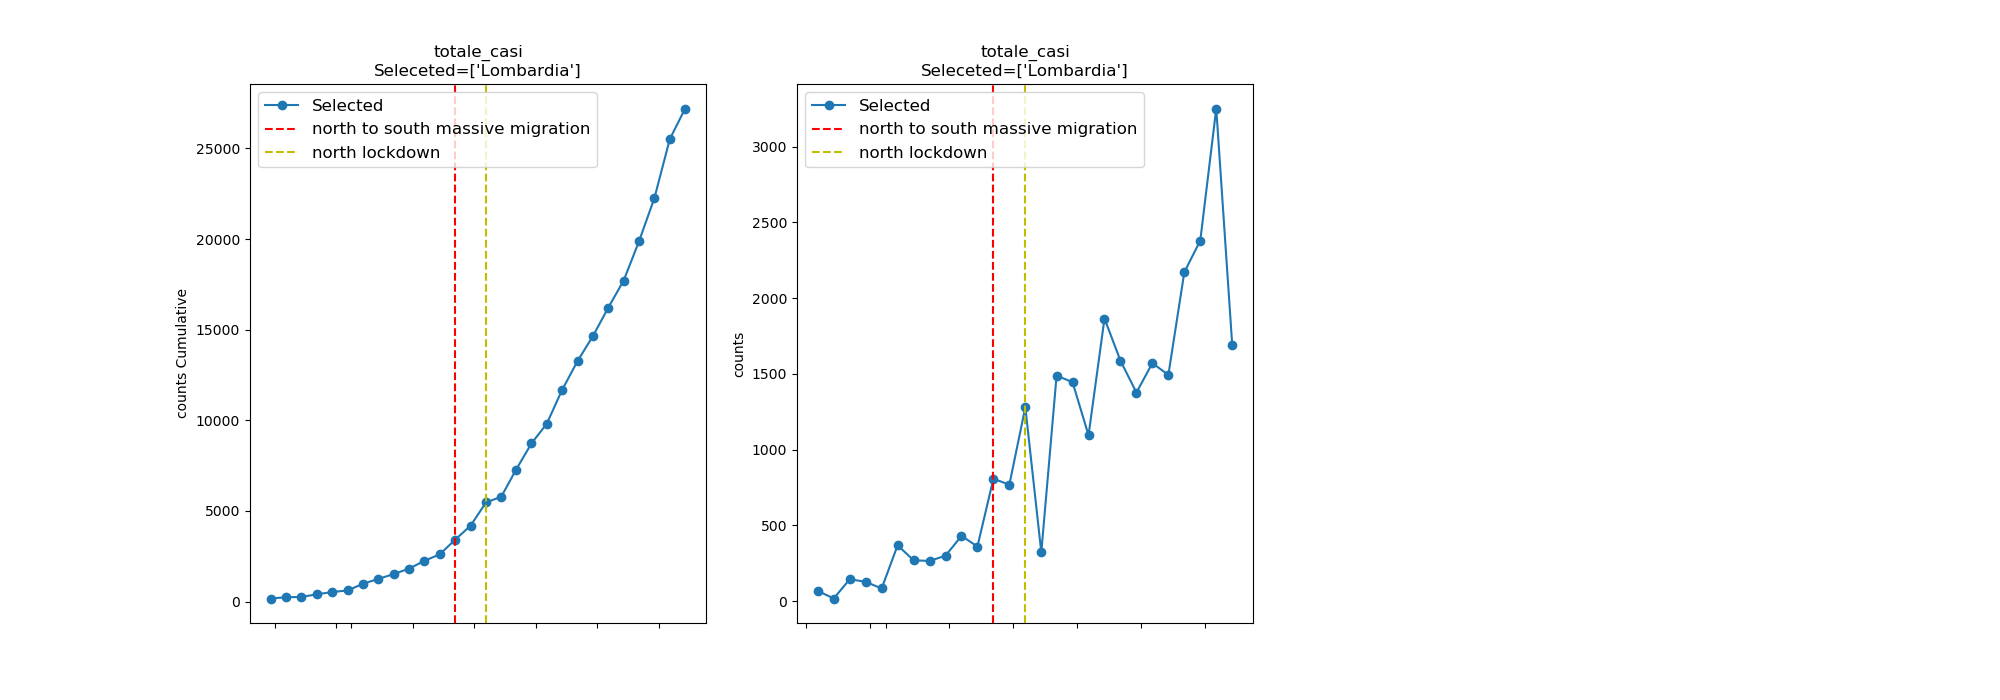

In [774]:
%matplotlib notebook
#plot_ratio('totale_casi',plot_vline=True,delta=-7,po_ratio=1.5,gradient=False,running_mean_window=0,selected_regions=None,ratio_class='tamponi',target_regions=None,skip_target=False,semilog=False)
plot_ratio('totale_casi',plot_vline=True,delta=-7,po_ratio=1.5,gradient=False,running_mean_window=0,selected_regions=['Lombardia'],target_regions=None,skip_target=False,semilog=False)


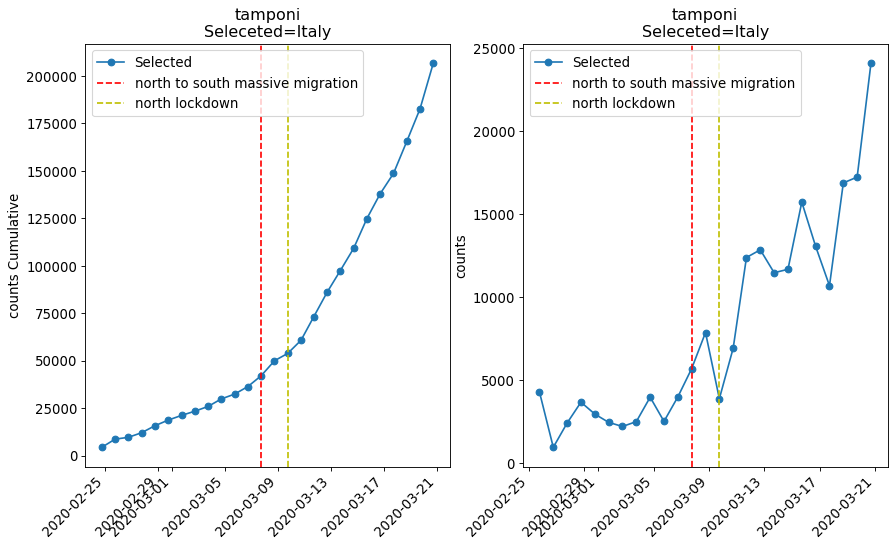

In [530]:
plot_ratio('tamponi',plot_vline=True,delta=0,po_ratio=1.5,gradient=False,running_mean_window=0,selected_regions=None,target_regions=None,skip_target=True,semilog=False)


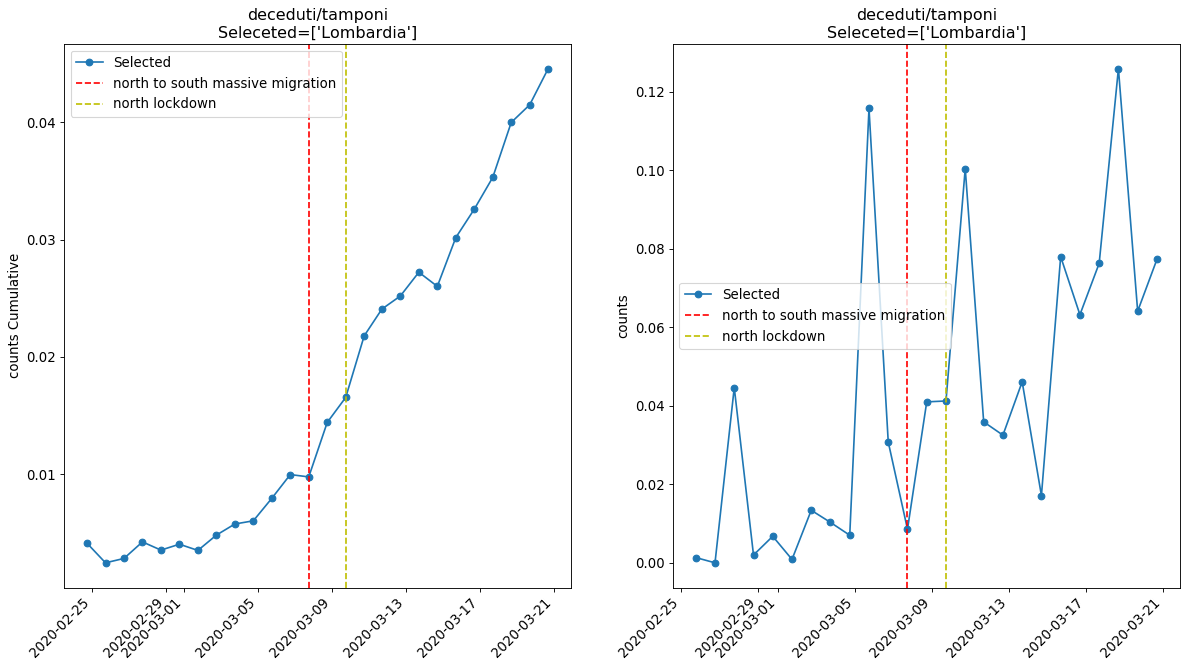

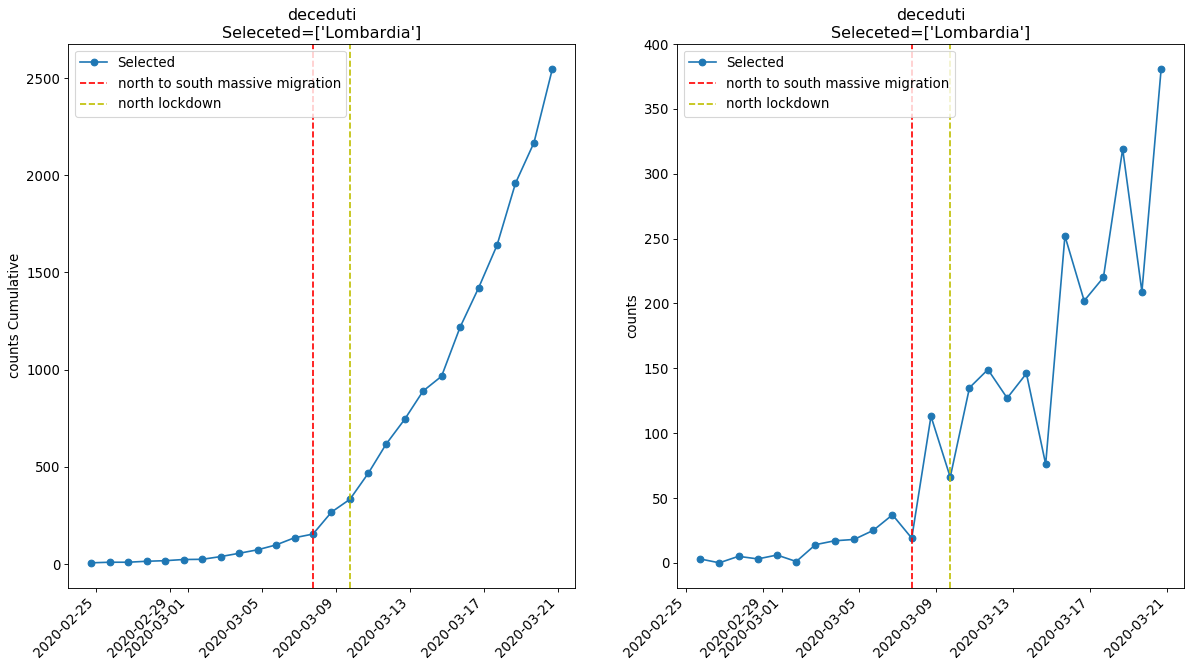

In [216]:
plot_ratio('deceduti',plot_vline=True,delta=None,po_ratio=0.0,gradient=False,running_mean_window=0,ratio_class='tamponi',skip_target=True,selected_regions=['Lombardia'],semilog=False)
plot_ratio('deceduti',plot_vline=True,delta=None,po_ratio=0.0,gradient=False,running_mean_window=0,skip_target=True,selected_regions=['Lombardia'],semilog=False)

In [237]:
df.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare',
       'totale_attualmente_positivi', 'nuovi_attualmente_positivi',
       'dimessi_guariti', 'deceduti', 'totale_casi', 'tamponi'],
      dtype='object')

In [257]:
data_full,data_diff_full,df_full =get_data_protezione_civile('deceduti',fake_error=False)    
df_full['totale_casi']/df_full['tamponi']
np.diff(df_full['totale_casi'])/np.diff(df_full['tamponi'].array)


array([0.02163294, 0.08091286, 0.10300783, 0.06465634, 0.08091706,
       0.22952149, 0.15419297, 0.18558343, 0.14745039, 0.30455446,
       0.19464598, 0.21865685, 0.18946032, 0.46207251, 0.1408796 ,
       0.18663762, 0.20619118, 0.22192211, 0.29934943, 0.22824083,
       0.24749292, 0.32968677, 0.24917081, 0.30877234, 0.24828902])

In [259]:
np.diff(df_full['tamponi'].array)

array([ 4299,   964,  2427,  3681,  2966,  2466,  2218,  2511,  3981,
        2525,  3997,  5703,  7875,  3889,  6935, 12393, 12857, 11477,
       11682, 15729, 13063, 10695, 16884, 17236, 24109])

# Montecarlo for logexp delay

In [731]:
from scipy.stats import logistic, genlogistic 
from scipy.stats import lognorm

(18.558572900230217, 7.682689445101587, 4.238719587021642, 69.72981746796208)

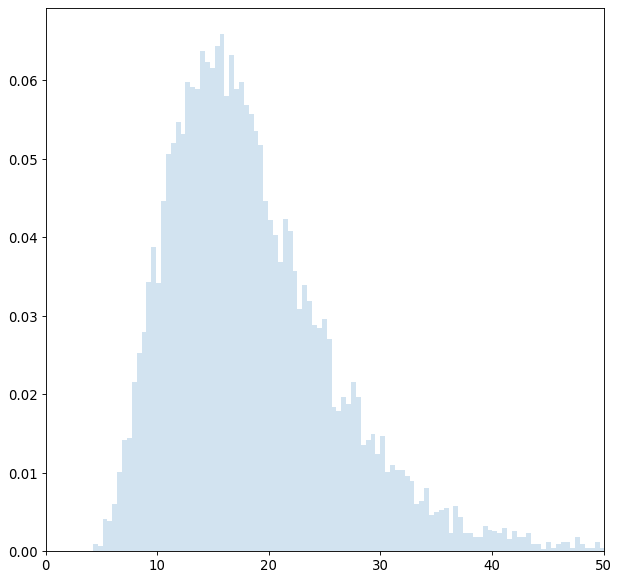

In [732]:
r = logistic.rvs(size=10000,scale=3,loc=20)
l = lognorm.rvs(s=0.4,scale=17.2,loc=0,size=10000)
plt.hist(l, density=True, histtype='stepfilled', alpha=0.2,bins=150)
plt.xlim(0,50)
l.mean(),l.std(),l.min(),l.max()

In [733]:
x=np.zeros(r.size)

In [734]:
#for ID,p in enumerate(r):
#    x[ID]=p+l[ID]
x=r+l   
days=np.linspace(0,69,70)
days

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69.])

Text(0.5, 0, 'days')

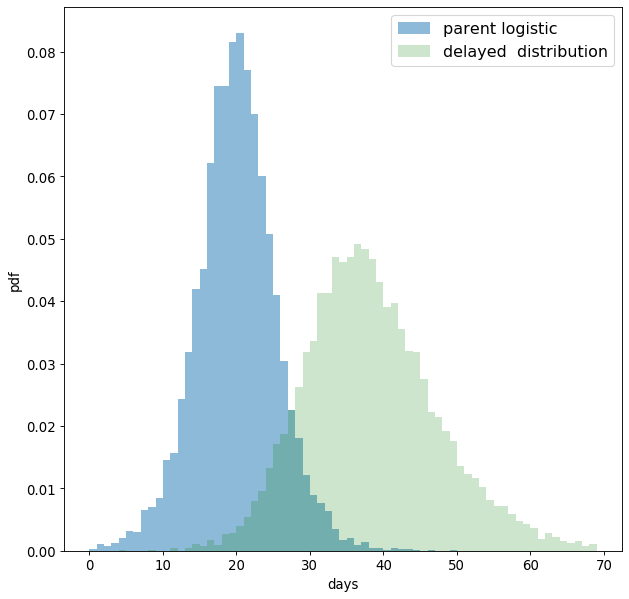

In [735]:
y_l=plt.hist(r,bins=days,density=True, histtype='stepfilled', alpha=0.5,cumulative=False,label='parent logistic')
#plt.hist(l, density=True, histtype='stepfilled', alpha=0.2)
y_d=plt.hist(x,bins=days, density=True, histtype='stepfilled', alpha=0.2,cumulative=False,label='delayed  distribution',color='green')
plt.legend(loc='best')
plt.ylabel('pdf')
plt.xlabel('days')

Text(0.5, 0, 'days')

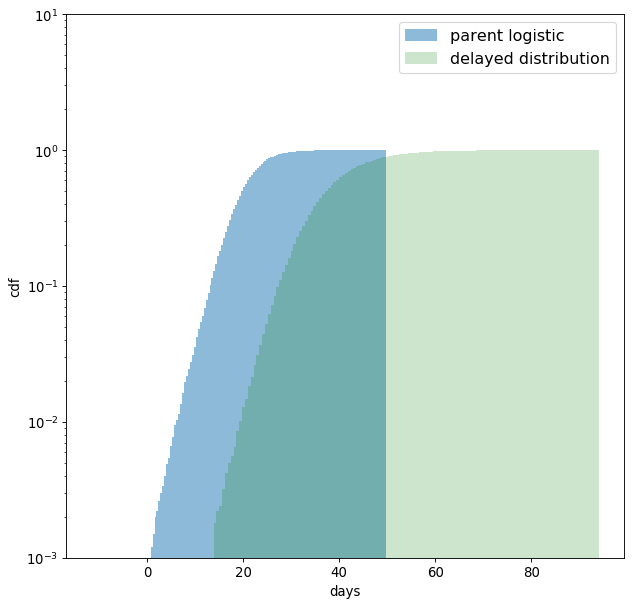

In [736]:
_=plt.hist(r,density=True, histtype='stepfilled', alpha=0.5,cumulative=True,bins=150,label='parent logistic')
#plt.hist(l, density=True, histtype='stepfilled', alpha=0.2)
_=plt.hist(x, density=True, histtype='stepfilled', alpha=0.2,cumulative=True,bins=150,label='delayed distribution',color='green')
plt.legend(loc='best')
plt.ylim(0.001,10)
plt.semilogy()
plt.ylabel('cdf')
plt.xlabel('days')


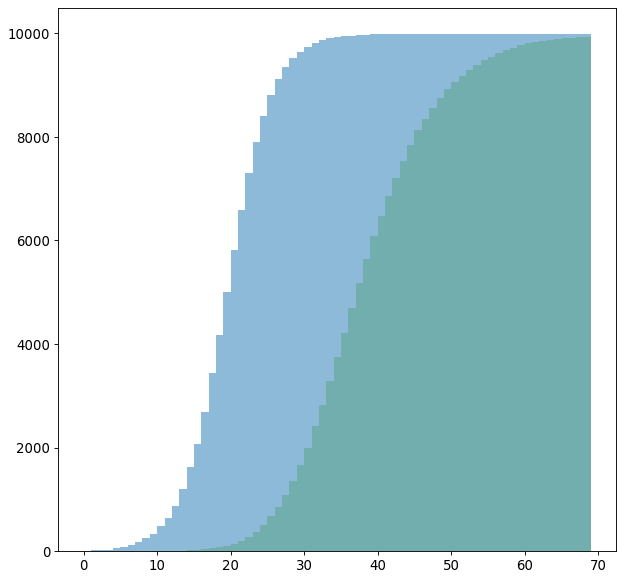

In [737]:
y_l=plt.hist(r,bins=days,density=False, histtype='stepfilled', alpha=0.5,cumulative=True,label='parent logistic')
#plt.hist(l, density=True, histtype='stepfilled', alpha=0.2)
y_d=plt.hist(x,bins=days, density=False, histtype='stepfilled', alpha=0.2,cumulative=True,label='delayed  distribution',color='green')

In [279]:
table_d=Table([days[1:] , y_d[0] , np.sqrt(y_d[0]), np.zeros(len(y_d[0]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
data_delayed=Data(table_d,pd.date_range(start='2/18/2020', periods=69).date)

table_l=Table([days[1:] , y_l[0] , np.sqrt(y_l[0]), np.zeros(len(y_l[0]),dtype=np.bool )],names=['nu_data','nuFnu_data','dnuFnu_data','UL'])
data_logistic=Data(table_l,pd.date_range(start='2/18/2020', periods=69).date)

  1%|          | 6/500 [00:00<00:08, 57.23it/s]

  model name  name bestfit val     err +     err -  start val   fit range min fit range max frozen
------------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticModel    N 4.493856e+03 3.387148e+02    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  tau 3.126194e+00 6.208709e-02    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  t_0 3.168328e+01 4.098852e-01    -- 0.000000e+00 -3.000000e+01            --  False
mcmc run starting


100%|██████████| 500/500 [00:09<00:00, 54.61it/s]


mcmc run done, with 1 threads took 9.18 seconds
bounds [[0, 13481.568085135896], [0.0, 9.378581109425324], [-30.0, 95.04984627074668]]

**************************************************************************************************
Fit report

Model: None
  model name  name par type units     val      phys. bound. min phys. bound. max  log  frozen
------------- ---- -------- ----- ------------ ---------------- ---------------- ----- ------
LogisticModel    N                4.205015e+03     0.000000e+00               -- False  False
LogisticModel  tau                3.031705e+00     0.000000e+00               -- False  False
LogisticModel  t_0                3.118088e+01    -3.000000e+01               -- False  False

converged=True
calls=302
------------------------------------------------------------------
| FCN = 16.52                   |     Ncalls=301 (301 total)     |
| EDM = 6.08E-07 (Goal: 1E-05)  |            up = 1.0            |
--------------------------------------------

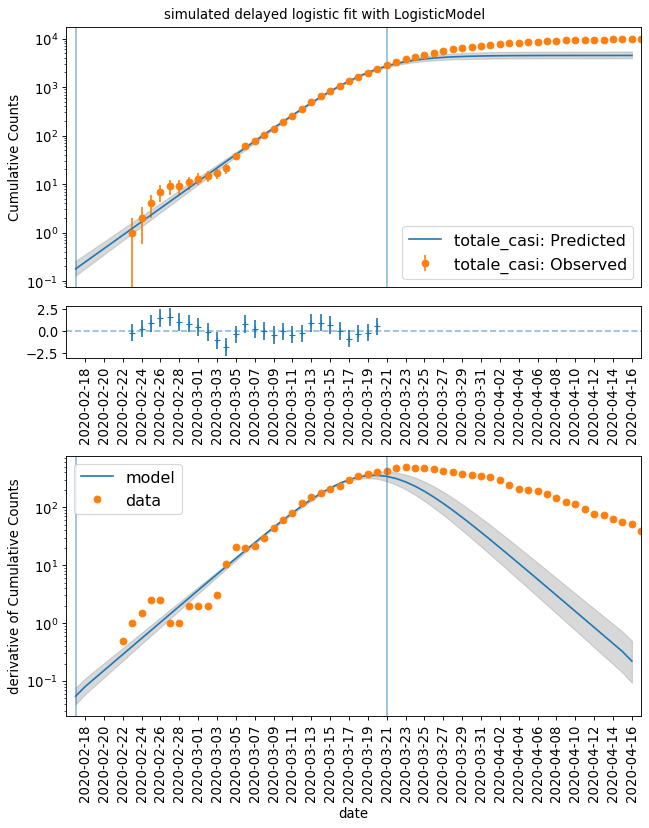

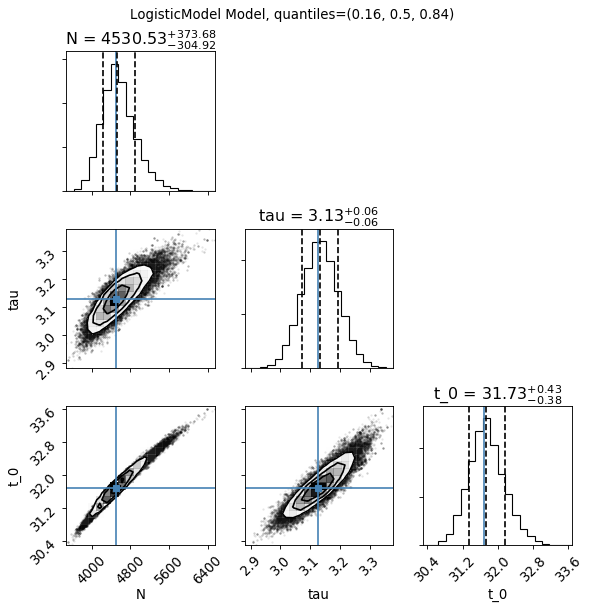

In [280]:
model=LogisticModel()
#model.parameters.t_0.val=-2
#model.parameters.tau.val=2

bfm,mm,mcmc,data,fig=do_analysis(model,
                                 data_delayed,
                                 t_start=0,
                                 t_stop=33,
                                 t_start_model=0,
                                 t_stop_model=60,
                                 name=name,
                                 mcmc_steps=500,
                                 title='simulated delayed logistic fit with %s'%model.name,
                                 do_mcmc=True,
                                 do_derivative=True)
if mcmc is not None:
    f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
    f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)

plt.tight_layout()
print(mm.show_report())

In [421]:
pd.date_range(start='1/3/2020', periods=69)

DatetimeIndex(['2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-11', '2020-01-12', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18',
               '2020-01-19', '2020-01-20', '2020-01-21', '2020-01-22',
               '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
               '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03',
               '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07',
               '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11',
               '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15',
               '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19',
               '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
      

  1%|          | 6/500 [00:00<00:08, 55.94it/s]

  model name  name bestfit val     err +     err -  start val   fit range min fit range max frozen
------------- ---- ------------ ------------ ----- ------------ ------------- ------------- ------
LogisticModel    N 9.591293e+03 5.628867e+01    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  tau 2.730215e+00 1.782346e-02    -- 1.000000e+00  0.000000e+00            --  False
LogisticModel  t_0 1.964664e+01 5.140303e-02    -- 0.000000e+00 -3.000000e+01            --  False
mcmc run starting


100%|██████████| 500/500 [00:08<00:00, 55.71it/s]


mcmc run done, with 1 threads took 9.00 seconds
bounds [[0, 28773.879394631294], [0.0, 8.19064629378789], [-19.646635612202616, 58.93990683660785]]

**************************************************************************************************
Fit report

Model: None
  model name  name par type units     val      phys. bound. min phys. bound. max  log  frozen
------------- ---- -------- ----- ------------ ---------------- ---------------- ----- ------
LogisticModel    N                9.580989e+03     0.000000e+00               -- False  False
LogisticModel  tau                2.737415e+00     0.000000e+00               -- False  False
LogisticModel  t_0                1.965141e+01    -3.000000e+01               -- False  False

converged=True
calls=206
------------------------------------------------------------------
| FCN = 159.5                   |     Ncalls=205 (205 total)     |
| EDM = 5.54E-06 (Goal: 1E-05)  |            up = 1.0            |
-------------------------------

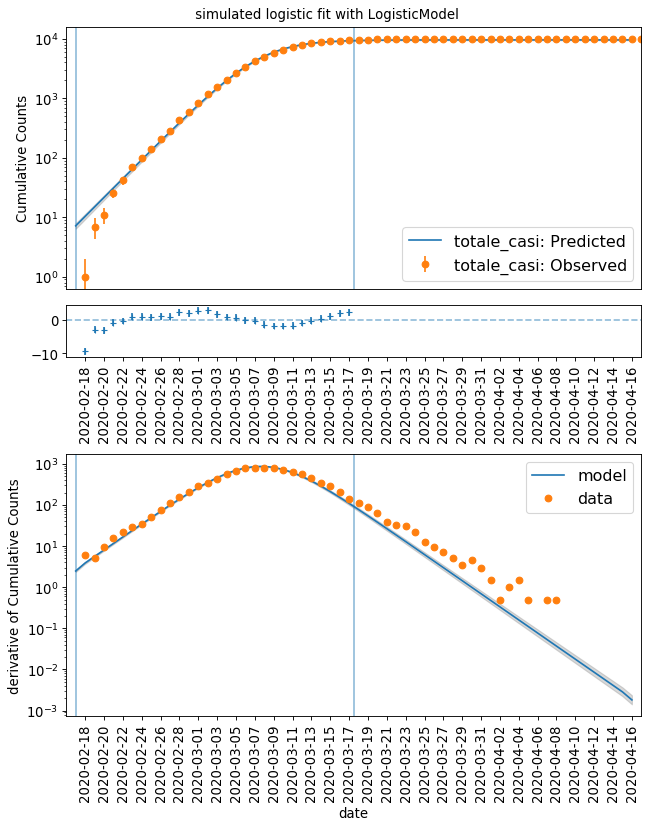

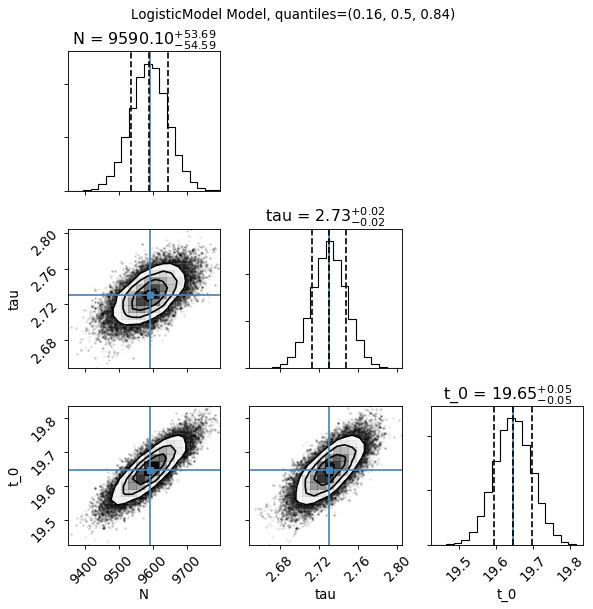

In [272]:
model=LogisticModel()
#model.parameters.t_0.val=-2
#model.parameters.tau.val=2

bfm,mm,mcmc,data,fig=do_analysis(model,
                                 data_logistic,
                                 t_start=0,
                                 t_stop=29.5,
                                 t_start_model=0,
                                 t_stop_model=60,
                                 name=name,
                                 mcmc_steps=500,
                                 title=' simulated logistic fit with %s'%model.name,
                                 do_mcmc=True,
                                 do_derivative=True)
if mcmc is not None:
    f=mcmc.corner_plot(quantiles=(0.16,0.5,0.84))
    f.suptitle('%s Model, quantiles=%s '%(model.name,str((0.16,0.5,0.84))),y=1.01)

plt.tight_layout()
print(mm.show_report())

# Definition of Logistic Dealyed using convolve

(<matplotlib.legend.Legend at 0x1ecdda390>, Text(0.5, 0.98, 'PMFs'))

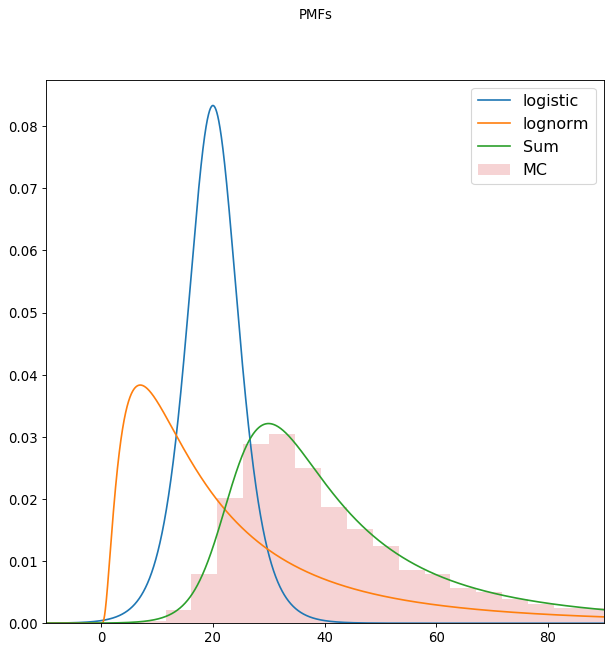

In [738]:
from scipy import stats
from scipy import signal
from scipy.stats import logistic, genlogistic 
from scipy.stats import lognorm, uniform
r = logistic(scale=3, loc=20)
#l = lognorm.rvs(s=0.2,scale=17.2,loc=0,size=10000)
l = lognorm(s=0.95,scale=17.2,loc=0)
# NB Kernel support array **MUST** be symmetric about centre of the kernel (error PDF) for this to work right. 
# Support also needs to extend about any significant areas of the component PDFs.
# Here, we just define one massive support for both input PDF, and error PDF (kernel)
# But we can do much better (see later)

#NB step-size determines precision of approximation
 
delta = 0.01
big_grid = np.arange(-100,100,delta)

# Cannot analytically convolve continuous PDFs, in general.
# So we now make a probability mass function on a fine grid 
# - a discrete approximation to the PDF, amenable to FFT...
pmf1 = r.pdf(big_grid)  
pmf2 = l.pdf(big_grid) 
conv_pmf = sp.signal.fftconvolve(pmf1,pmf2,'same') # Convolved probability mass function
conv_pmf = conv_pmf/np.trapz(conv_pmf,big_grid)

plt.plot(big_grid,pmf1, label='logistic')
plt.plot(big_grid,pmf2, label='lognorm')
plt.plot(big_grid,conv_pmf, label='Sum')

#check with MC
r = logistic.rvs(size=10000,scale=3,loc=20)
l = lognorm.rvs(s=0.95,scale=17.2,loc=0,size=10000)
c=r+l
plt.hist(c, density=True, histtype='stepfilled', alpha=0.2,bins=150,label='MC')
plt.xlim(-10,90)
plt.legend(loc='best'), plt.suptitle('PMFs')

(<matplotlib.legend.Legend at 0x1eca98350>, Text(0.5, 0.98, 'PMFs'))

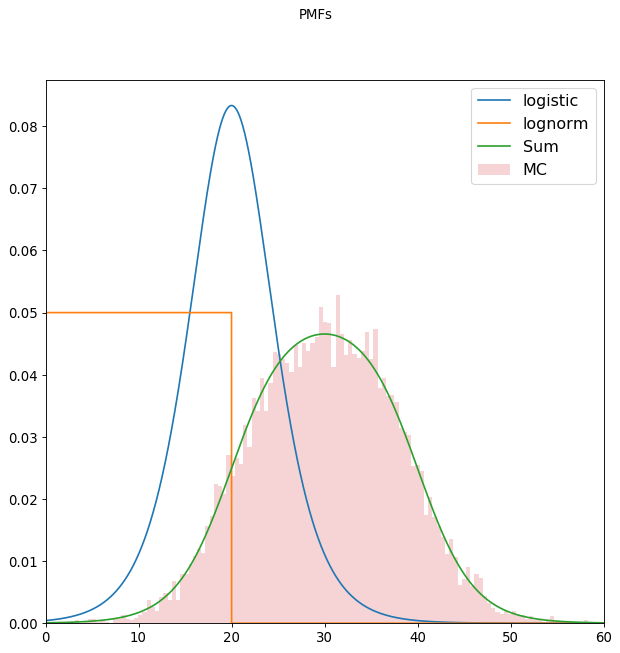

In [739]:
from scipy import stats
from scipy import signal
from scipy.stats import logistic, genlogistic 
from scipy.stats import lognorm, uniform
r = logistic(scale=3, loc=20)
#l = lognorm.rvs(s=0.2,scale=17.2,loc=0,size=10000)
#l = lognorm(s=0.95,scale=17.2,loc=0)
l=uniform(0,20)
# NB Kernel support array **MUST** be symmetric about centre of the kernel (error PDF) for this to work right. 
# Support also needs to extend about any significant areas of the component PDFs.
# Here, we just define one massive support for both input PDF, and error PDF (kernel)
# But we can do much better (see later)

#NB step-size determines precision of approximation
 
delta = 0.001
big_grid = np.arange(-100,100,delta)

# Cannot analytically convolve continuous PDFs, in general.
# So we now make a probability mass function on a fine grid 
# - a discrete approximation to the PDF, amenable to FFT...
pmf1 = r.pdf(big_grid)  
pmf2 = l.pdf(big_grid) 
conv_pmf = sp.signal.fftconvolve(pmf1,pmf2,'same') # Convolved probability mass function
conv_pmf = conv_pmf/np.trapz(conv_pmf,big_grid)

plt.plot(big_grid,pmf1, label='logistic')
plt.plot(big_grid,pmf2, label='lognorm')
plt.plot(big_grid,conv_pmf, label='Sum')

#check with MC
r = logistic.rvs(size=10000,scale=3,loc=20)
l = uniform.rvs(0,20,size=10000)
c=r+l
plt.hist(c, density=True, histtype='stepfilled', alpha=0.2,bins=150,label='MC')
plt.xlim(0,60)
plt.legend(loc='best'), plt.suptitle('PMFs')

In [837]:
from scipy.stats import poisson

In [847]:
poisson.cdf(86,86+np.sqrt(86))

0.18516849275049943

In [849]:
1-(0.5+0.32)

0.17999999999999994